<a href="https://colab.research.google.com/github/Jcc329/Jessica_DATA606/blob/main/Notebooks/4_Text_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 606 Capstone
## Notebook 4
## Phase 1 Part 2: Text Exploration
Jessica Conroy

<b> Goal: </b> 
This Notebook aims to perform basic text analysis for the identification of key game features. 
1. Overall Keyword and NGram extraction from game description, reviews, tags
2. Segmentation by pre-Covid and during-Covid
3. Clustering

In [1]:
# !pip install matplotlib==3.5.1
!pip install yellowbrick

In [2]:
!pip install pytextrank

In [3]:
!pip install yake

In [4]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 4.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer, DispersionPlot, PosTagVisualizer

import gensim
from gensim.summarization import keywords
from io import TextIOWrapper

import pytextrank
import spacy
from operator import itemgetter

import yake

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
#Load Data
GameData = pd.read_csv('./FinalSteamData.csv')
GameData.head()

,Unnamed: 0,type,name,required_age,is_free,detailed_description,short_description,Review Score,Review Score Description,Top Reviews by Upvotes,appid,positive,negative,owners,price,initialprice,discount,metacritic,Single-player,Steam Achievements,Steam Workshop,Steam Cloud,Includes level editor,Downloadable Content,Multi-player,Shared/Split Screen,Full controller support,Steam Trading Cards,Remote Play Together,Partial Controller Support,Steam Leaderboards,Captions available,Stats,PvP,Online PvP,Co-op,Online Co-op,MMO,In-App Purchases,Shared/Split Screen PvP,Shared/Split Screen Co-op,Cross-Platform Multiplayer,LAN PvP,LAN Co-op,Valve Anti-Cheat enabled,Remote Play on TV,VR Support,Remote Play on Phone,Remote Play on Tablet,Action,Casual,Indie,Simulation,Strategy,Early Access,Racing,RPG,Adventure,Education,Game Development,Massively Multiplayer,Design & Illustration,Web Publishing,Violent,Gore,Sports,Animation & Modeling,Audio Production,Software Training,Utilities,Video Production,Photo Editing,mac,linux,Release Date,detailed_description.1,short_description.1,Top Reviews by Upvotes.1,tags.1,Release Year
0,1,game,White Eyes,0,False,The universe implodes and interstellar nomads ...,The universe implodes and interstellar nomads ...,0.0,1 user reviews,Don't normally like games that stretch my ref...,1676720.0,1.0,0.0,"0 .. 20,000",1499.0,1499.0,0.0,{},1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"26 Jul, 2021",universe implodes interstellar nomads race get...,universe implodes interstellar nomads race get...,normally like games stretch reflexes far game ...,action 73 casual 67 arcade 45 shoot em up 40 2...,2021.0
1,3,dlc,My Neighborhood Arcade: RC Targets - Dronez Unit,0,False,Pilot an RC drone through a target course In R...,Pilot an RC drone through a target course In R...,0.0,No user reviews,NaN,1423248.0,0.0,0.0,"0 .. 20,000",399.0,399.0,0.0,{},1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"26 Sep, 2020",pilot rc drone target course rc targets dronez...,pilot rc drone target course rc targets dronez...,NaN,NaN,2020.0
2,4,dlc,My Neighborhood Arcade: RC Targets - Dronez Unit,0,False,Pilot an RC drone through a target course In R...,Pilot an RC drone through a target course In R...,0.0,No user reviews,NaN,1423248.0,0.0,0.0,"0 .. 20,000",399.0,399.0,0.0,{},1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"26 Sep, 2020",pilot rc drone target course rc targets dronez...,pilot rc drone target course rc targets dronez...,NaN,NaN,2020.0
3,5,game,Pixel Galaxy,0,False,<h1>ALL Serenity Forge games on Sale!</h1><p>W...,A non-shooting shoot 'em up where you must gro...,7.0,Positive,"I wish this was more enjoyable to play, but it...",370480.0,149.0,19.0,"20,000 .. 50,000",999.0,999.0,0.0,"{'score': 68, 'url': 'https://www.metacritic.c...",1,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,False,"2 Oct, 2015",serenity forge games salewe hope take opportun...,nonshooting shoot em must grow make friends su...,wish enjoyable play not difficult see comparis...,bullet hell 83 coop 71 shoot em up 70 replay v...,2015.0
4,6,game,Alien Shooter 2: Reloaded,0,False,Alien Shooter 2 -Reloaded is a large-scale seq...,Alien Shooter 2 -Reloaded is a large-scale seq...,8.0,Very Positive,"I like to shoot aliens, but not in this game.m...",33120.0,1886.0,159.0,"200,000 .. 500,000",499.0,499.0,0.0,{},1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"27 May, 2009",alien shooter 2 reloaded largescale sequel fir...,alien shooter 2 reloaded largescale sequel fir...,like shoot aliens gamemy childhood nightmare t...,action 176 shooter 170 action rpg 169 shoot em...,2009.0


In [3]:
#Remove digits from tags. Turns out these arent going to be helpful
def removedigit(s):
    try:
        s = re.sub("\d+", "", s)
    except: 
        s
    return s
GameData['tags.1'] = GameData['tags.1'].apply(removedigit)
GameData['tags.1']

0        action  casual  arcade  shoot em up  d  colorf...
1                                                      NaN
2                                                      NaN
3        bullet hell  coop  shoot em up  replay value  ...
4        action  shooter  action rpg  shoot em up  rpg ...
                               ...                        
14947    adventure  indie  point  click  puzzle  short ...
14948                                                  NaN
14949                                   adventure  casual 
14950                                                  NaN
14951                                                  NaN
Name: tags.1, Length: 14952, dtype: object

In [8]:
#Function from: https://github.com/VintageGold/Text_Summarization/blob/main/notebooks/EDA.ipynb

def countplots(data,dataset_name,vectorizers,cols=4,):

    rows = len(vectorizers)
    cols = cols #dynamically change n_grams and plots

    fig, ax = plt.subplots(rows,cols,figsize=(30,15))
    fig.tight_layout(h_pad=2,w_pad=cols*4)

    for index, vect in enumerate(vectorizers):

        for i in range(cols):

            vectorizer = vect(stop_words=None,ngram_range=(i+1,i+1),lowercase=True)
            
            vectorizer_name = str(vectorizer)
            
            vectorizer_title = vectorizer_name[:vectorizer_name.find("(")]
            
            documents = vectorizer.fit_transform(data)
            
            features = vectorizer.get_feature_names()
            
            if len(vectorizers) < 2:
                axis = ax[i]
            else:
                axis = ax[index][i]
            
            visualizer = FreqDistVisualizer(features=features, orient="h",n=15,ax=axis)
            
            _ = sns.set(font_scale = 3)  
            
            axis.set_title(f"Dataset: {dataset_name} - {vectorizer_title} {vectorizer.ngram_range}")
            
            
            _ = visualizer.fit(documents) 
            
            #ax[index,i].set_yticklabels([textwrap.fill(phrase, 20) for phrase in data.head(25)])
            

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


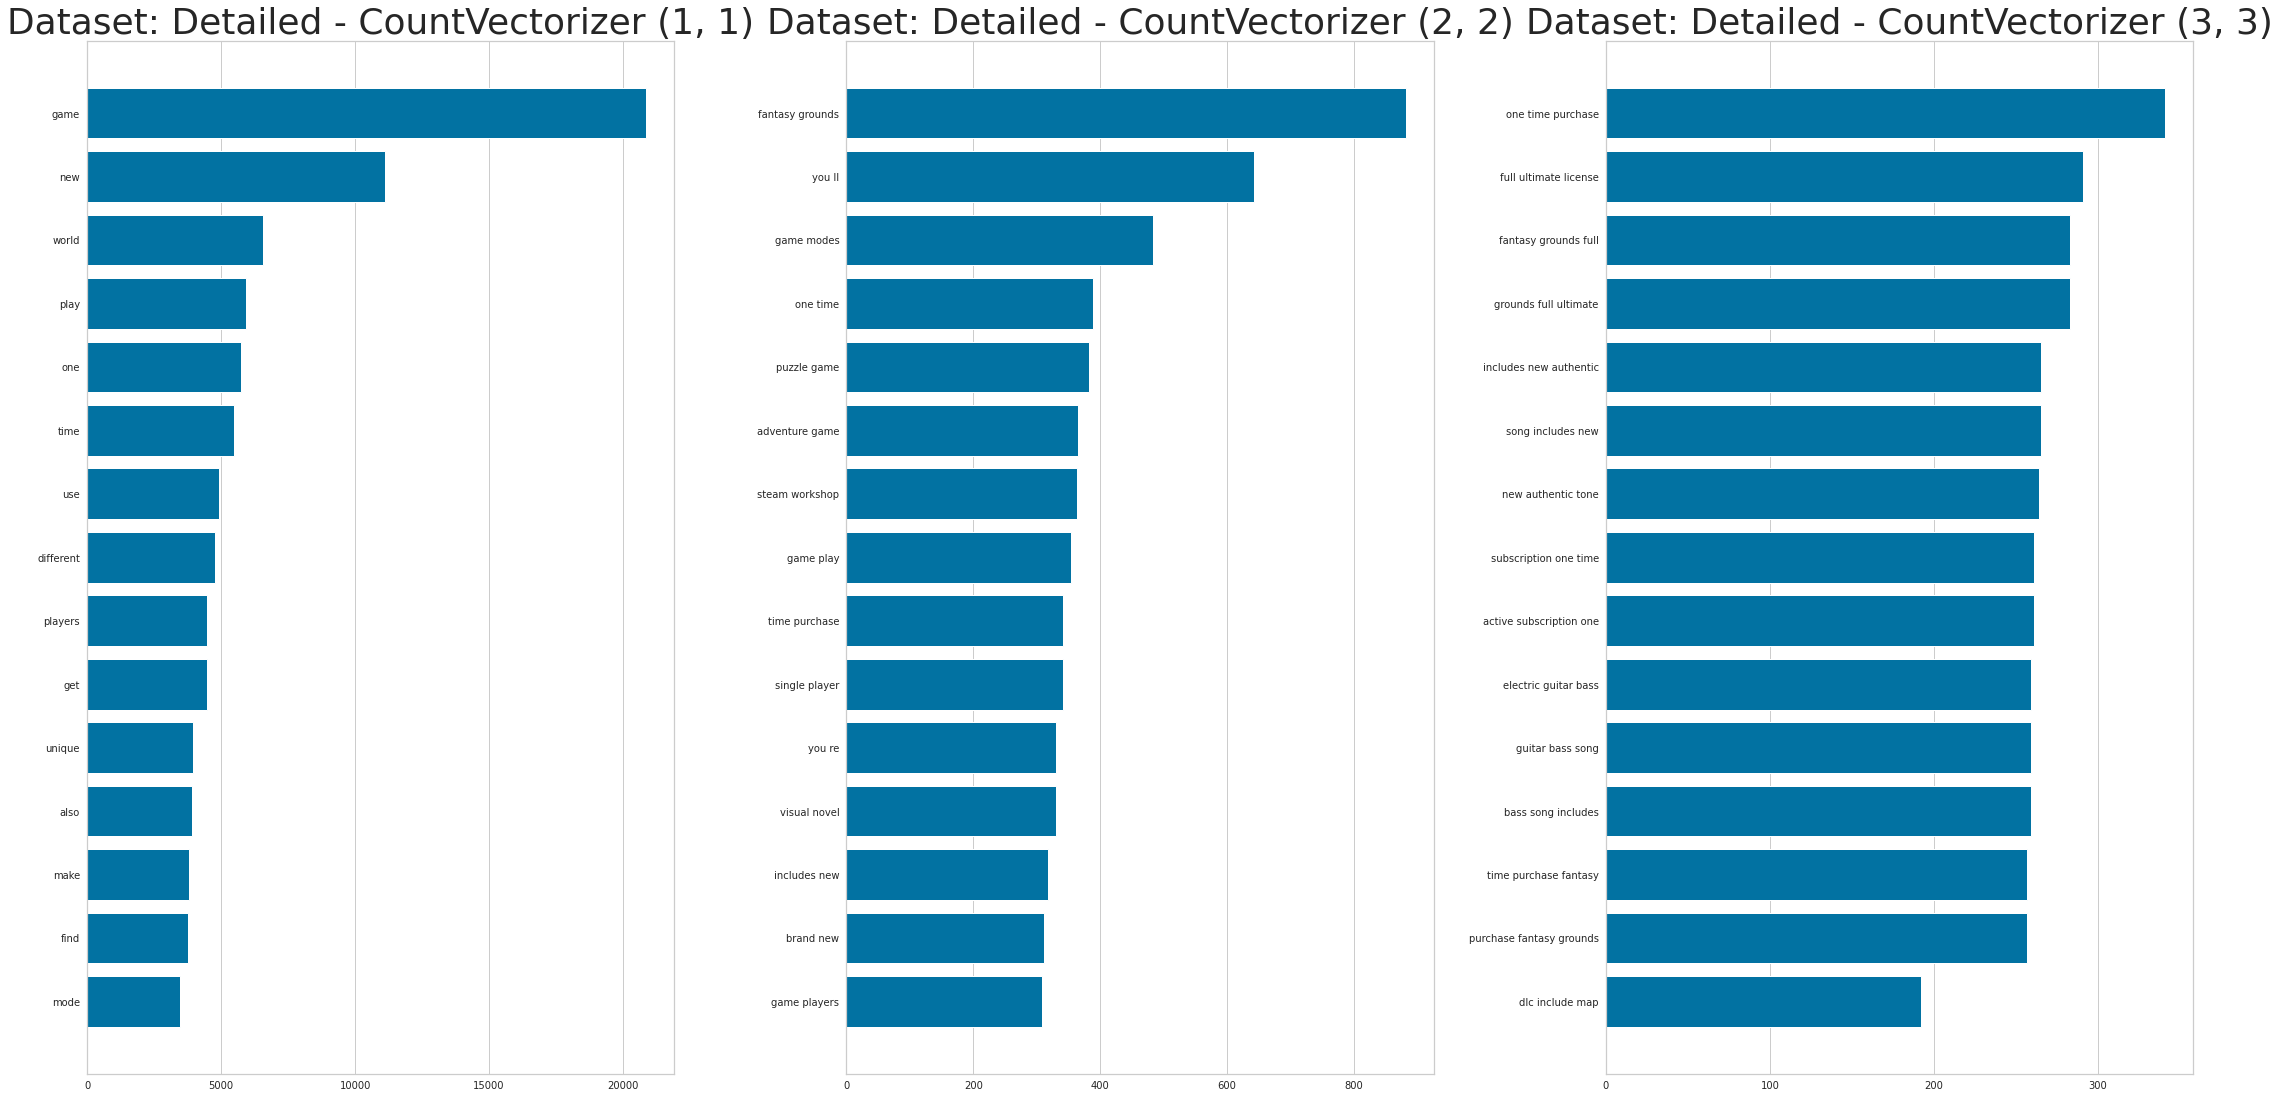

In [9]:
countplots(GameData[GameData["detailed_description.1"].isnull() ==False]["detailed_description.1"],"Detailed",[CountVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


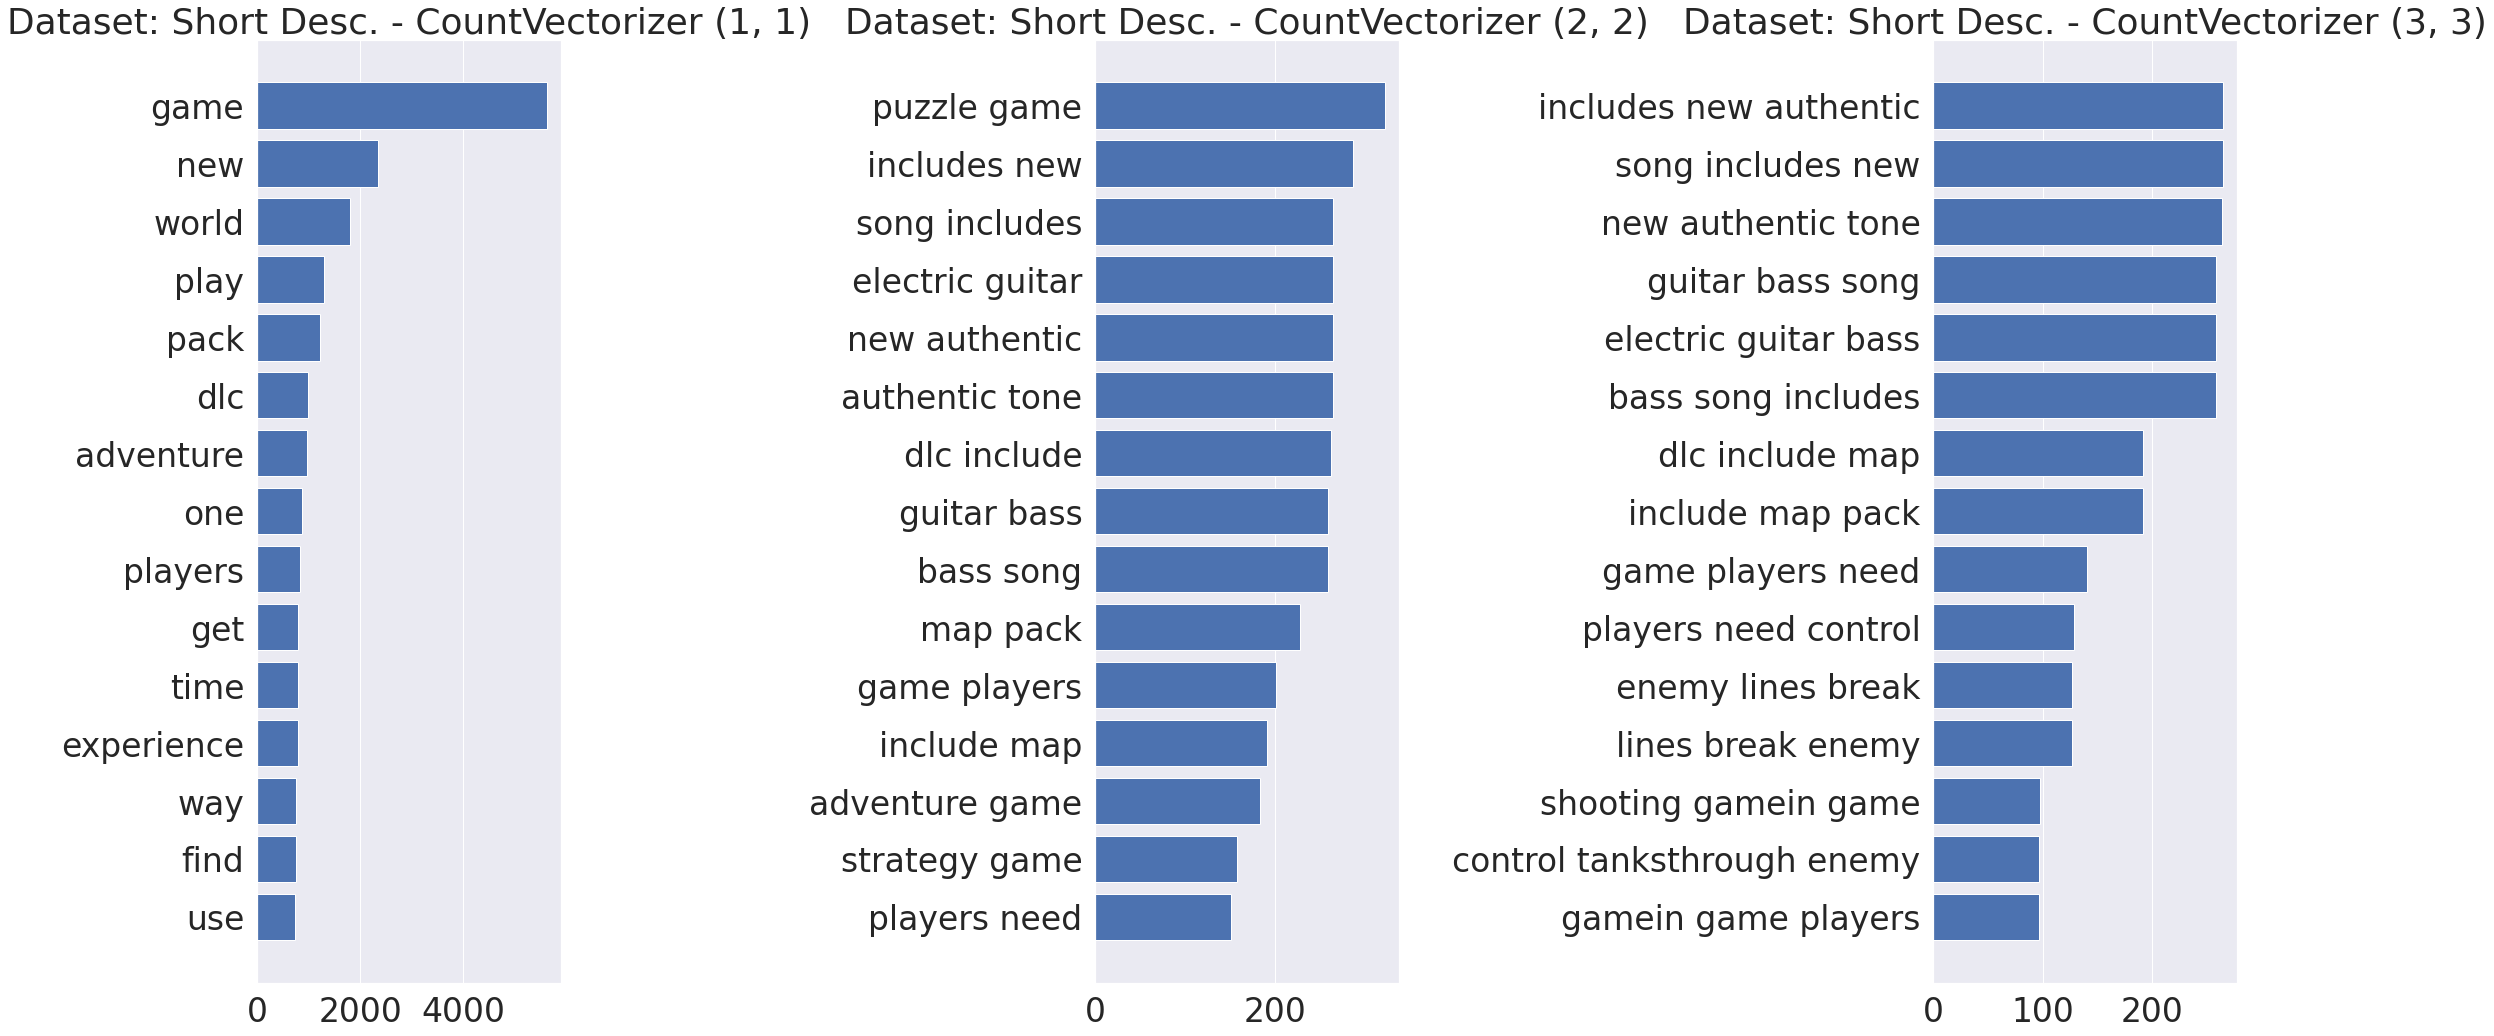

In [10]:
countplots(GameData[GameData["short_description.1"].isnull() ==False]["short_description.1"],"Short Desc.",[CountVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


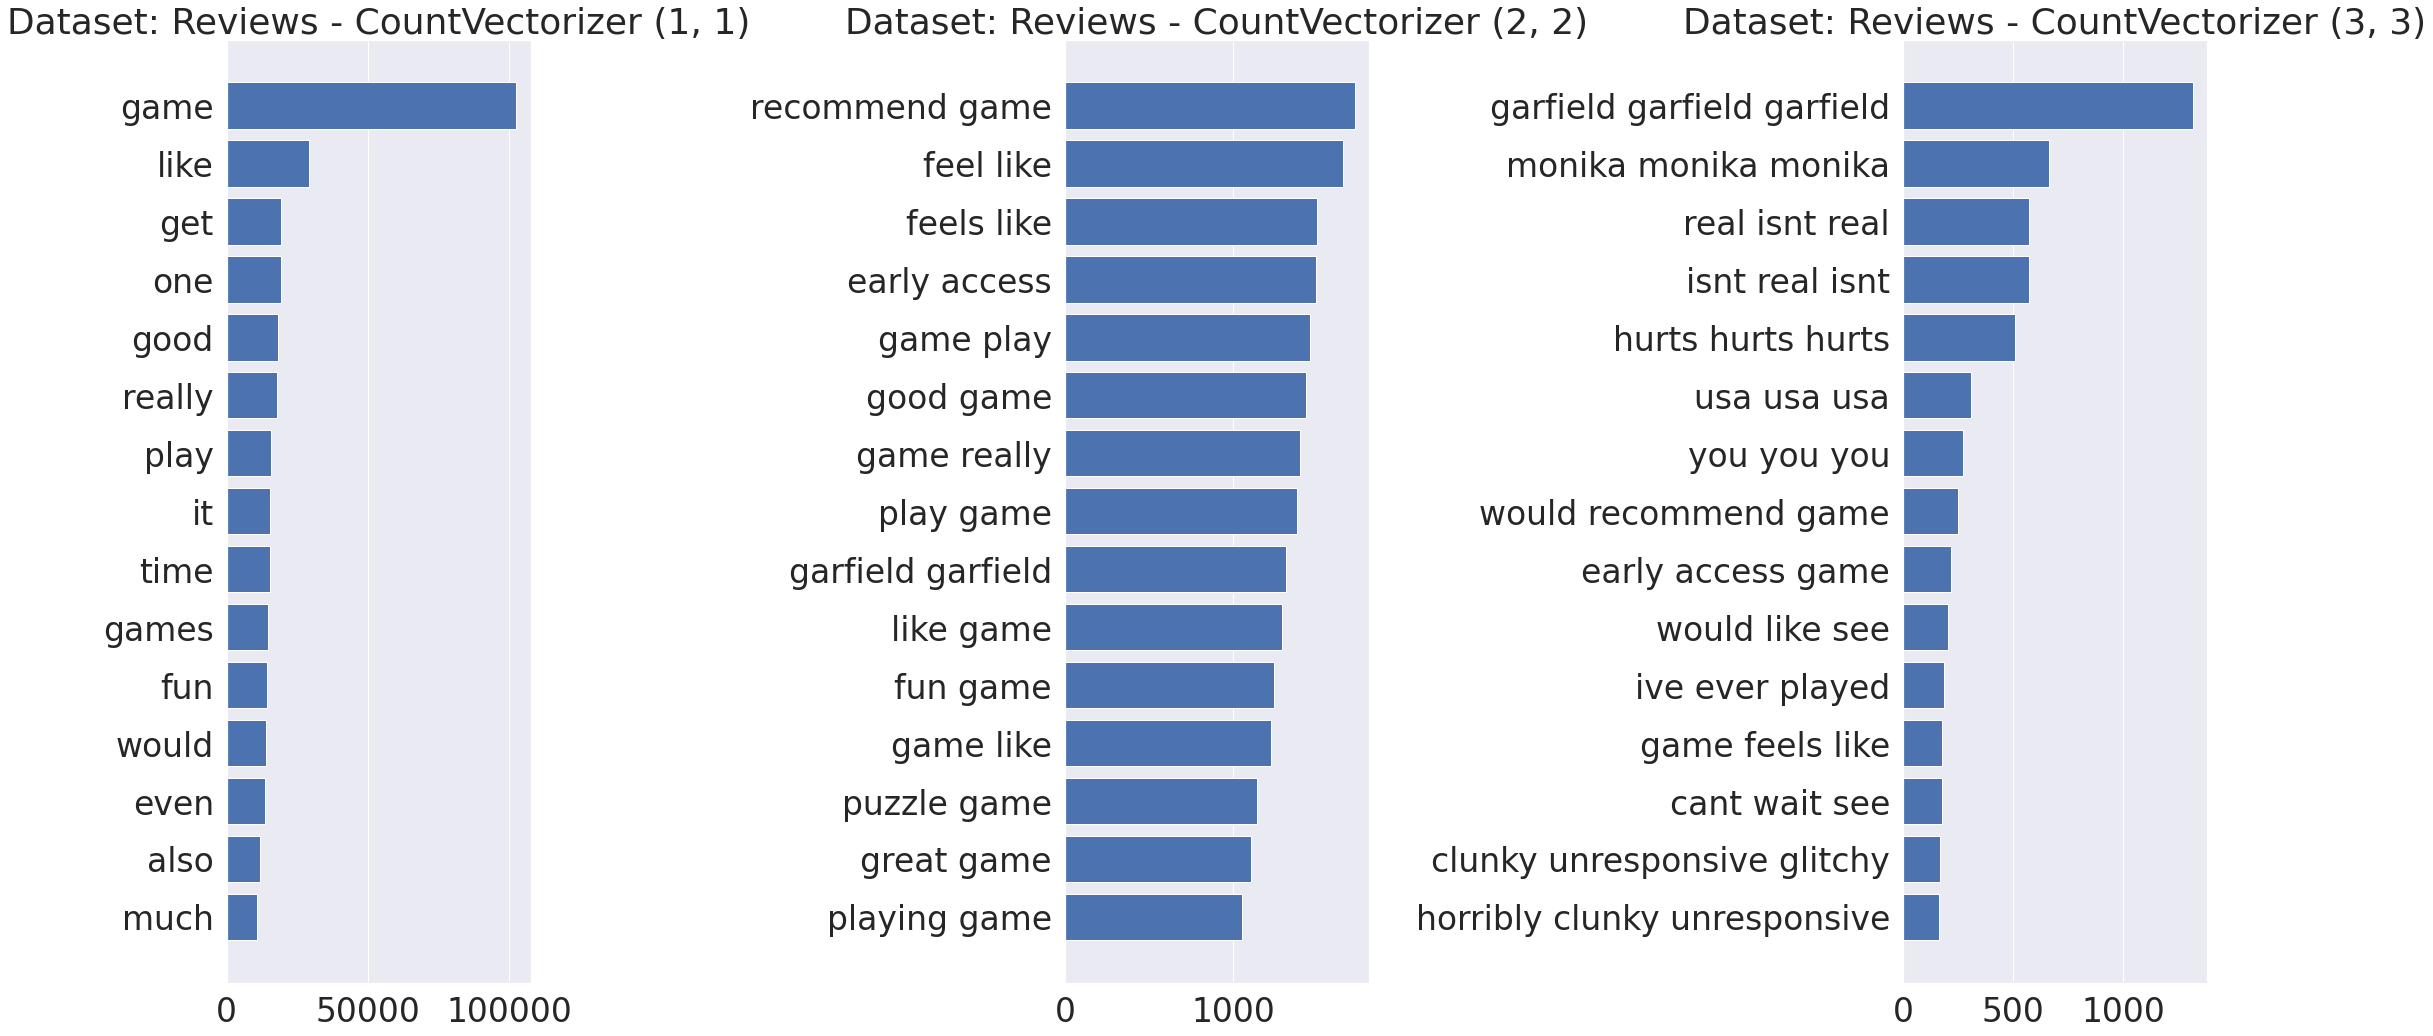

In [11]:
countplots(GameData[GameData["Top Reviews by Upvotes.1"].isnull() ==False]["Top Reviews by Upvotes.1"],"Reviews",[CountVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


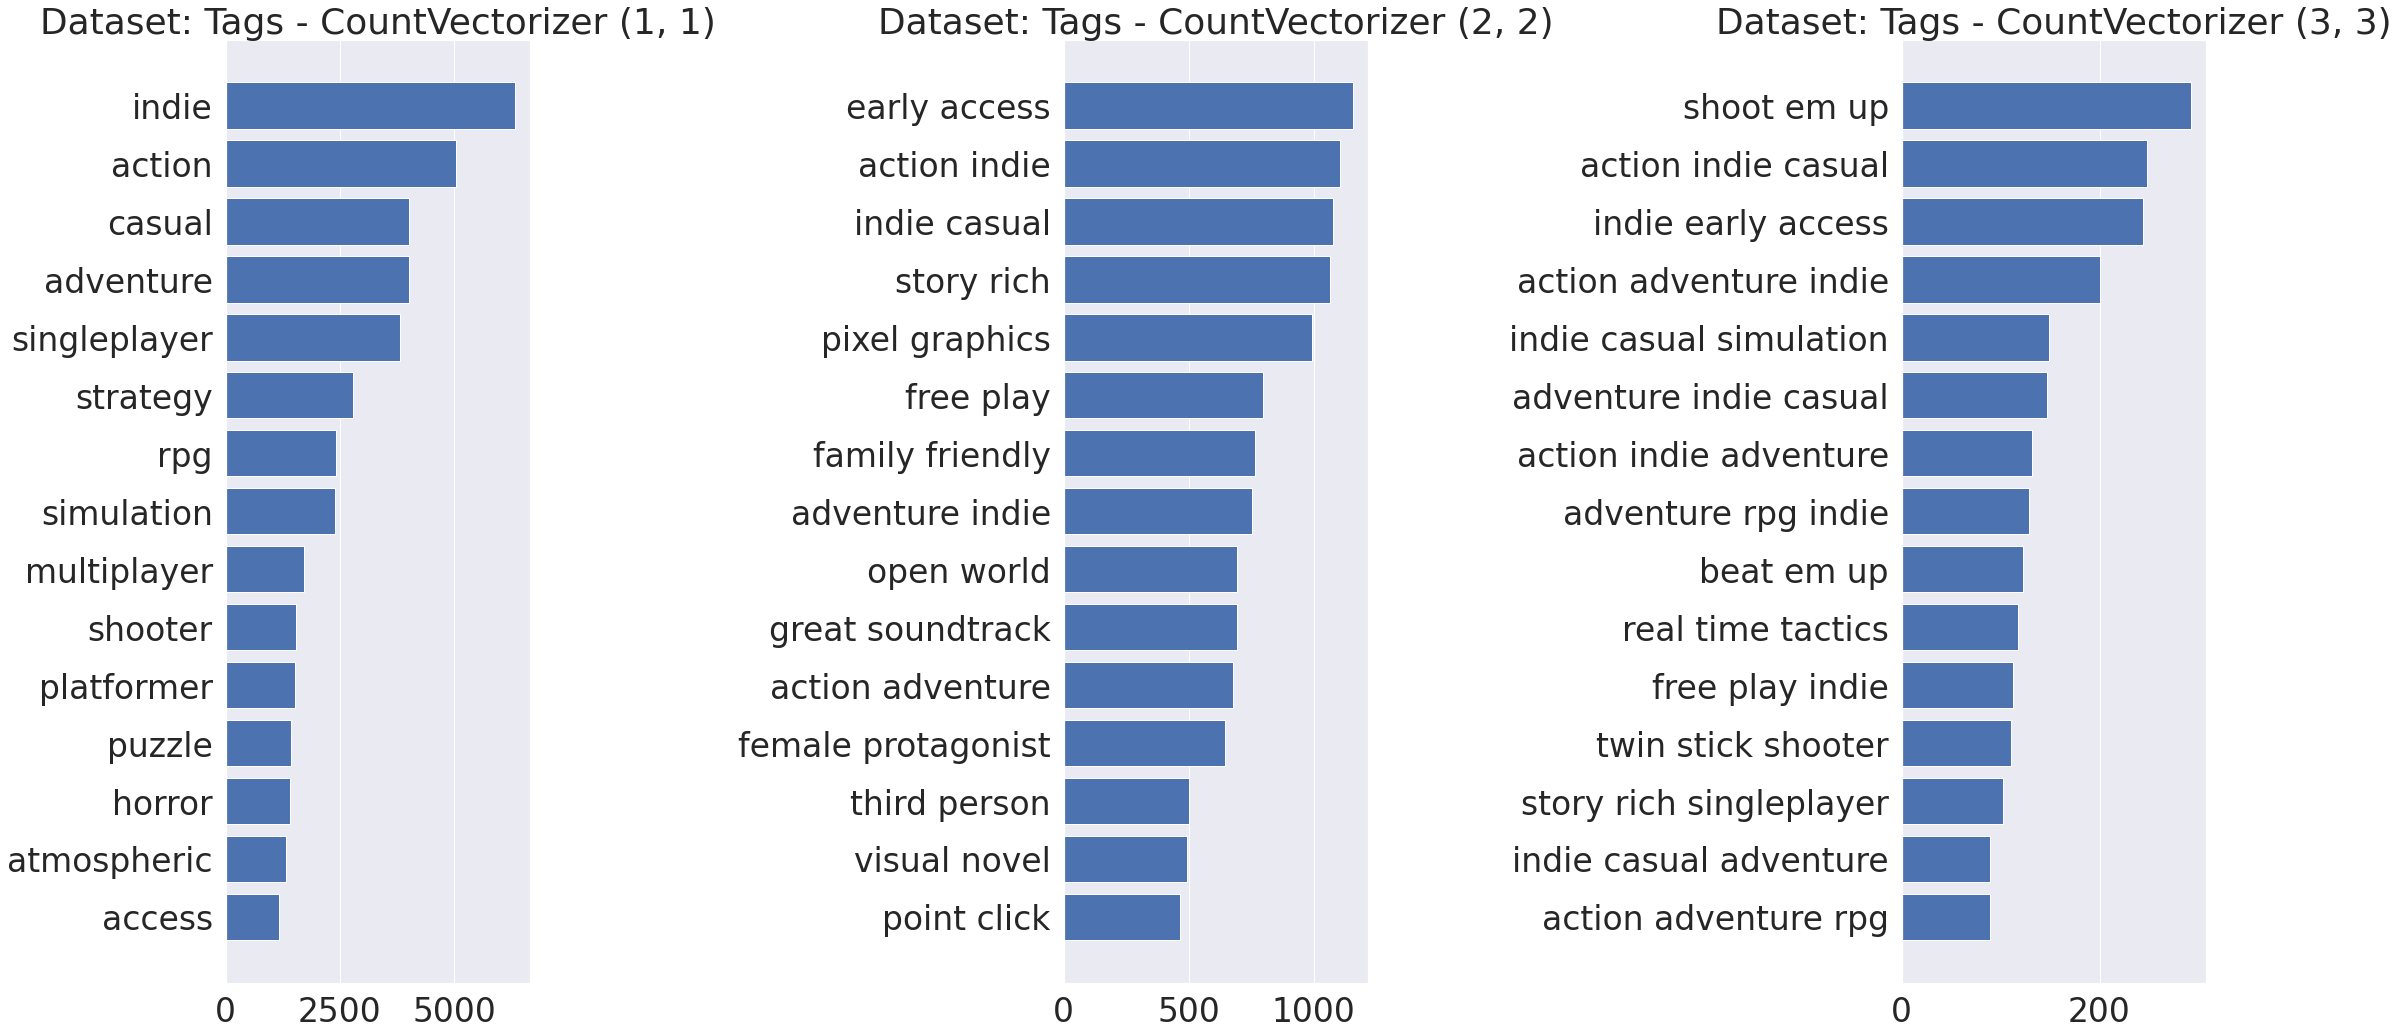

In [12]:
countplots(GameData[GameData["tags.1"].isnull() ==False]['tags.1'],"Tags",[CountVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


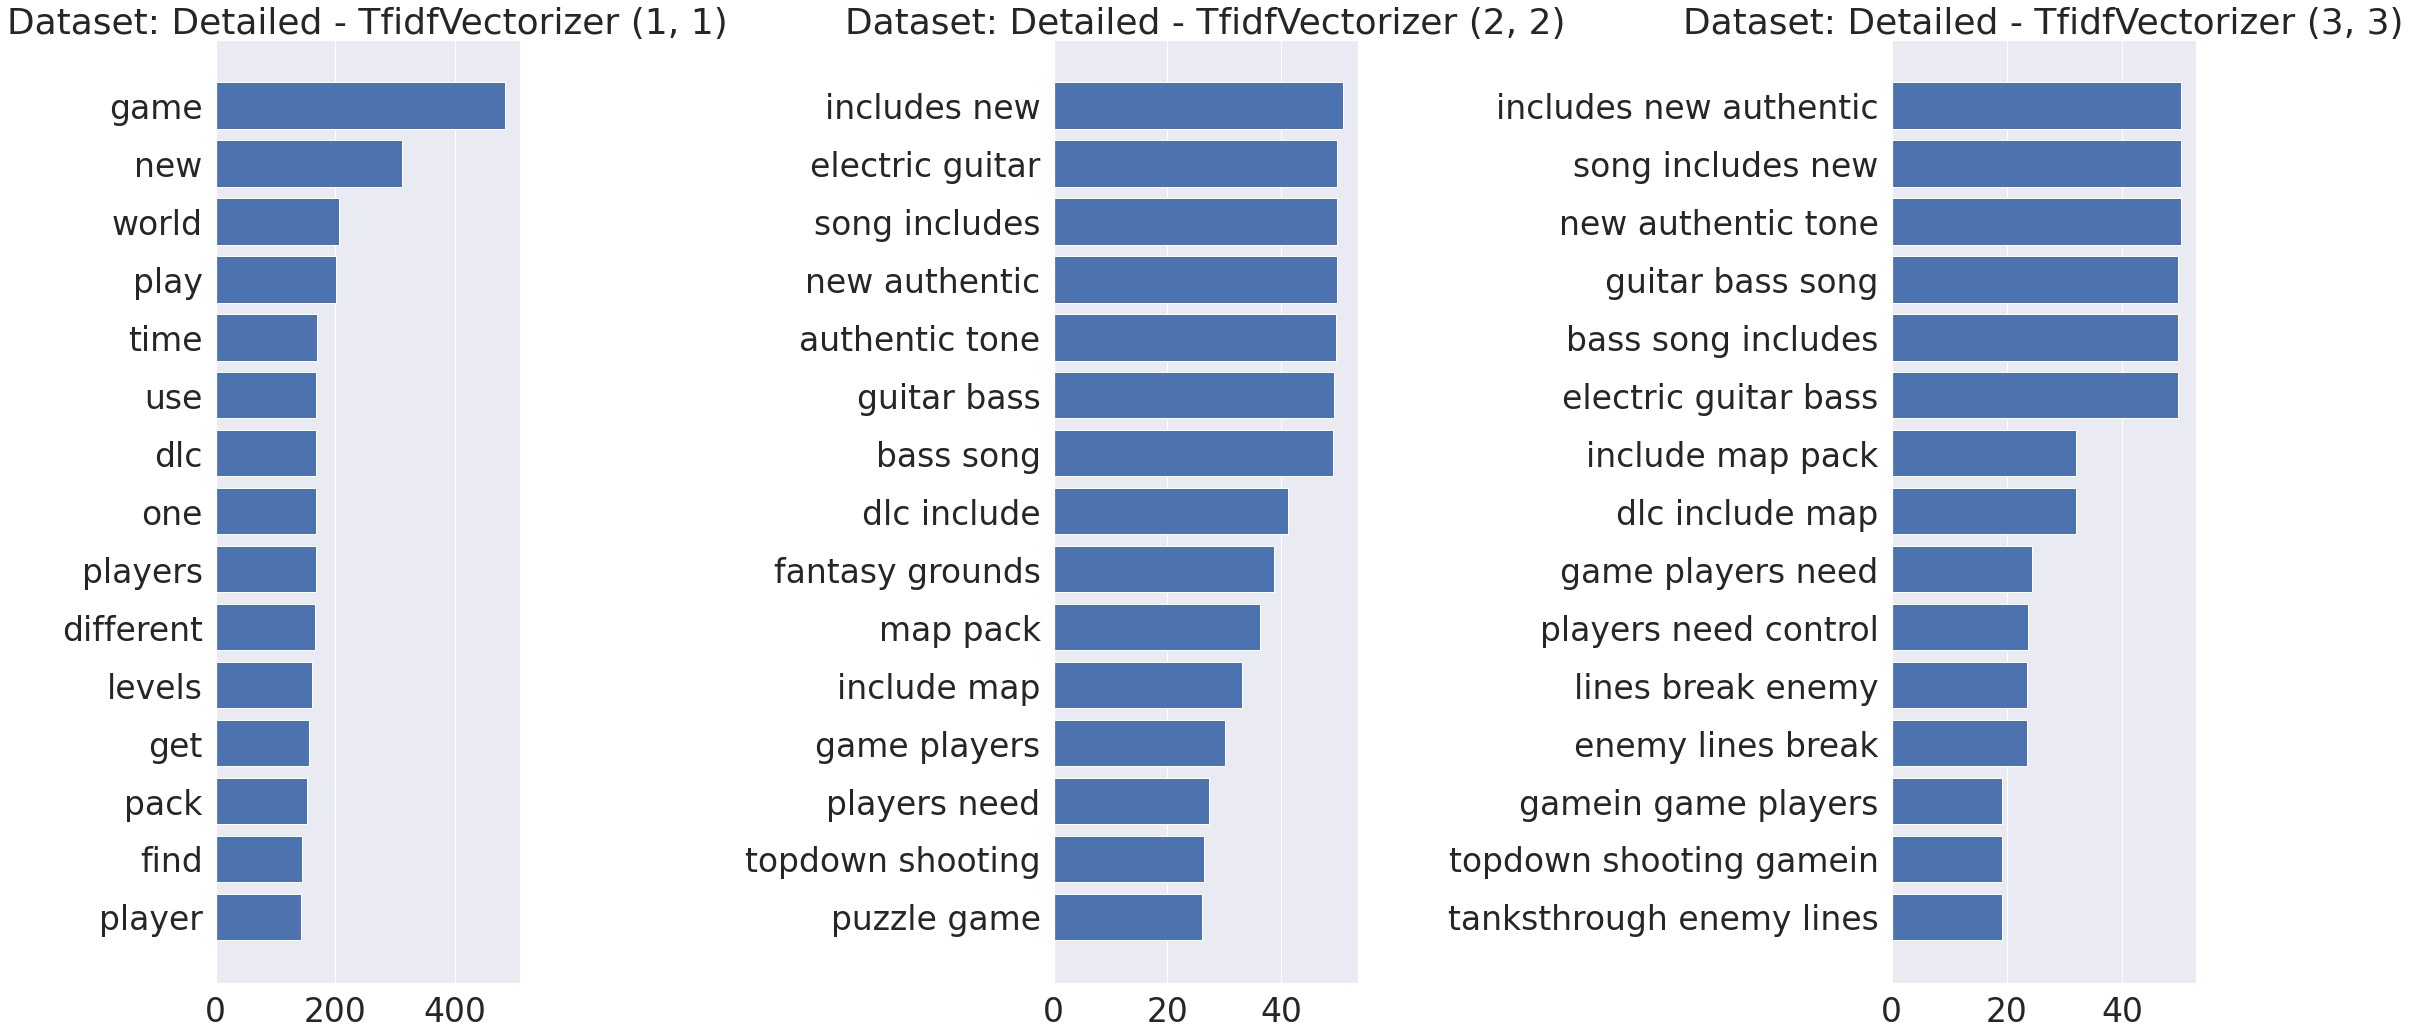

In [13]:
countplots(GameData[GameData["detailed_description.1"].isnull() ==False]["detailed_description.1"],"Detailed",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


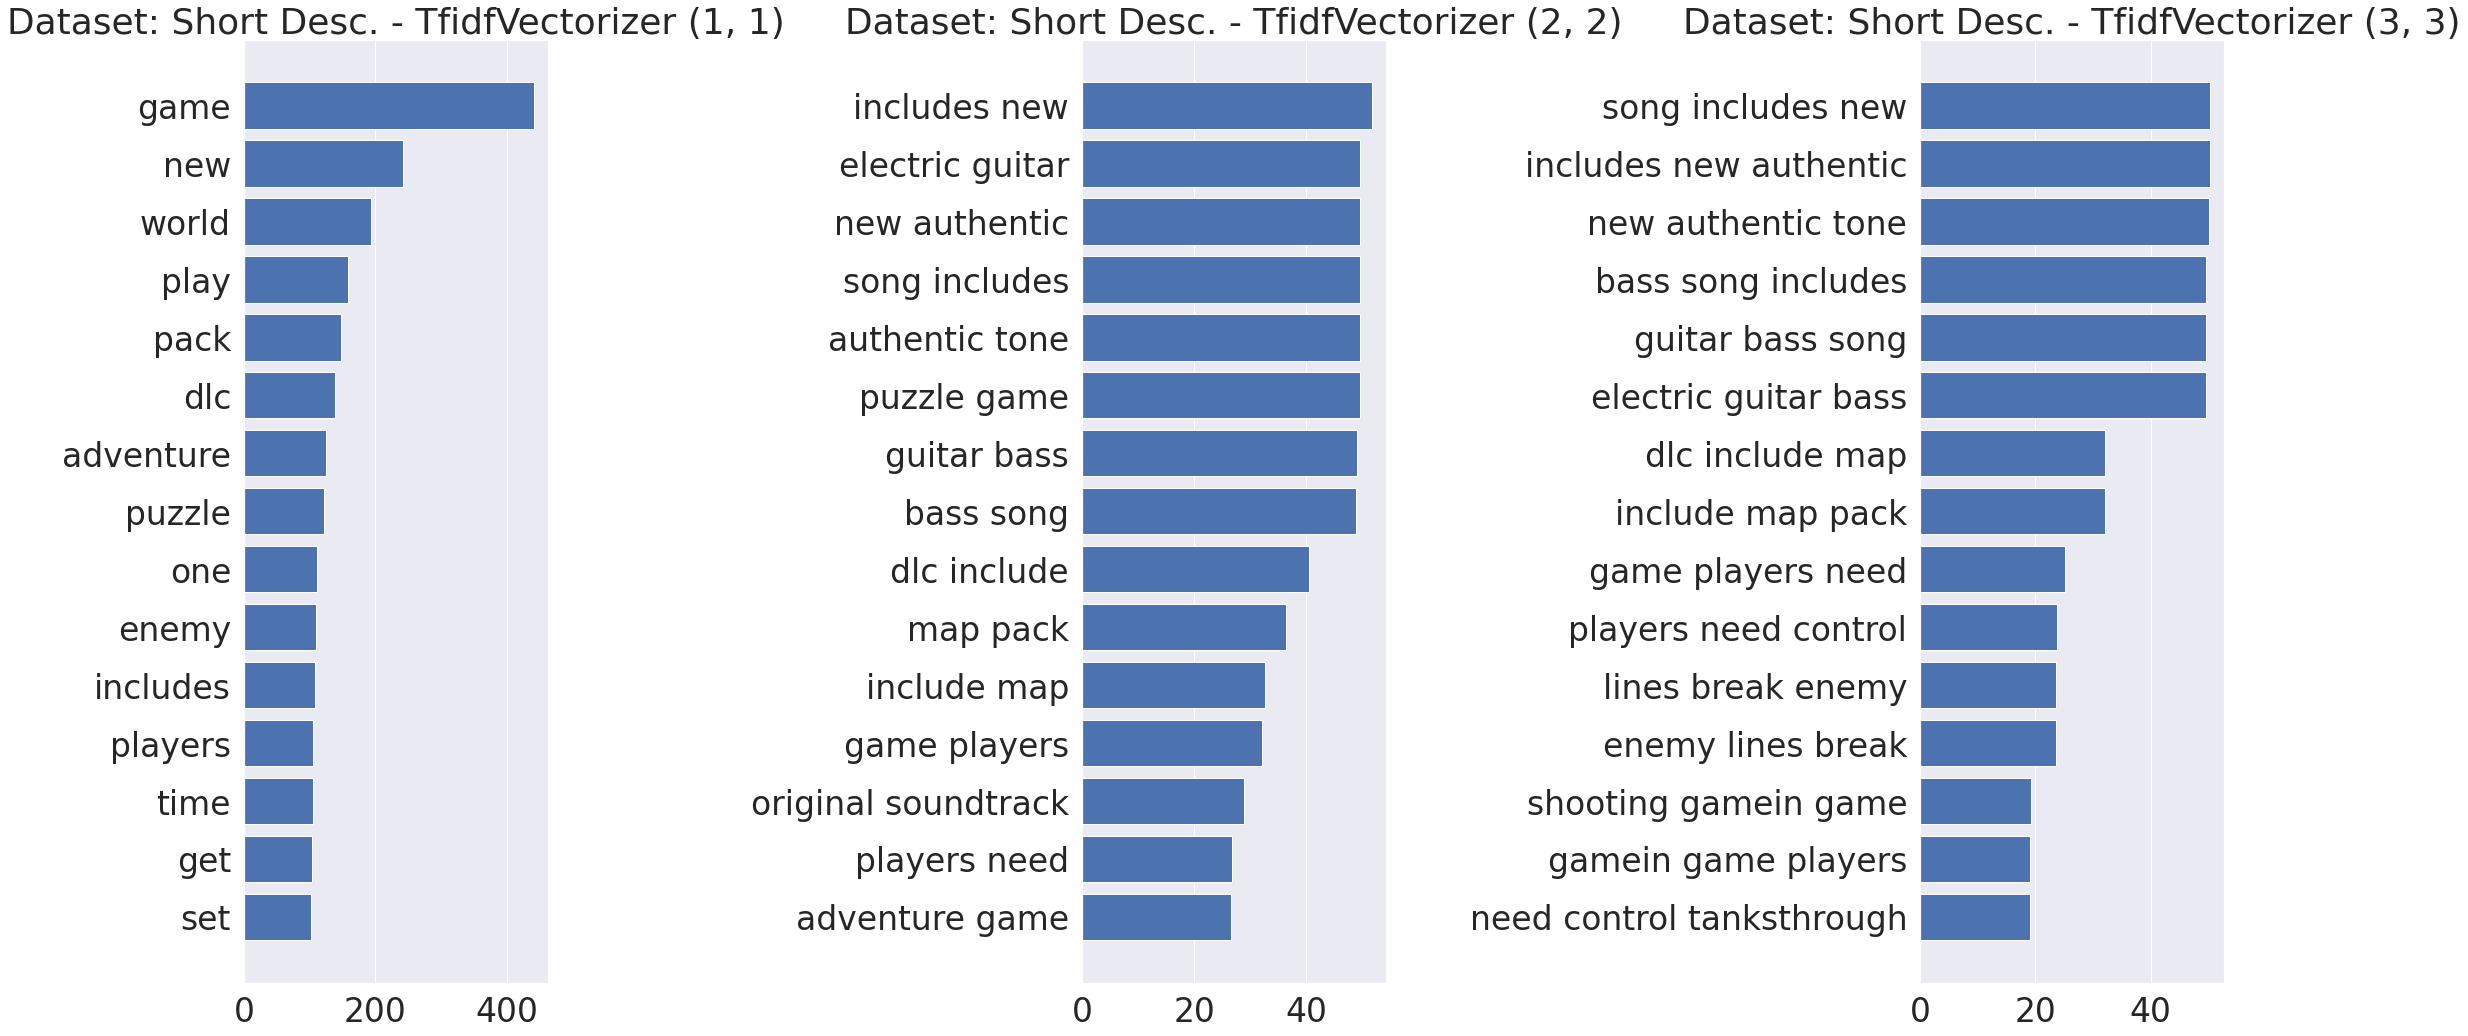

In [14]:
countplots(GameData[GameData["short_description.1"].isnull() ==False]["short_description.1"],"Short Desc.",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


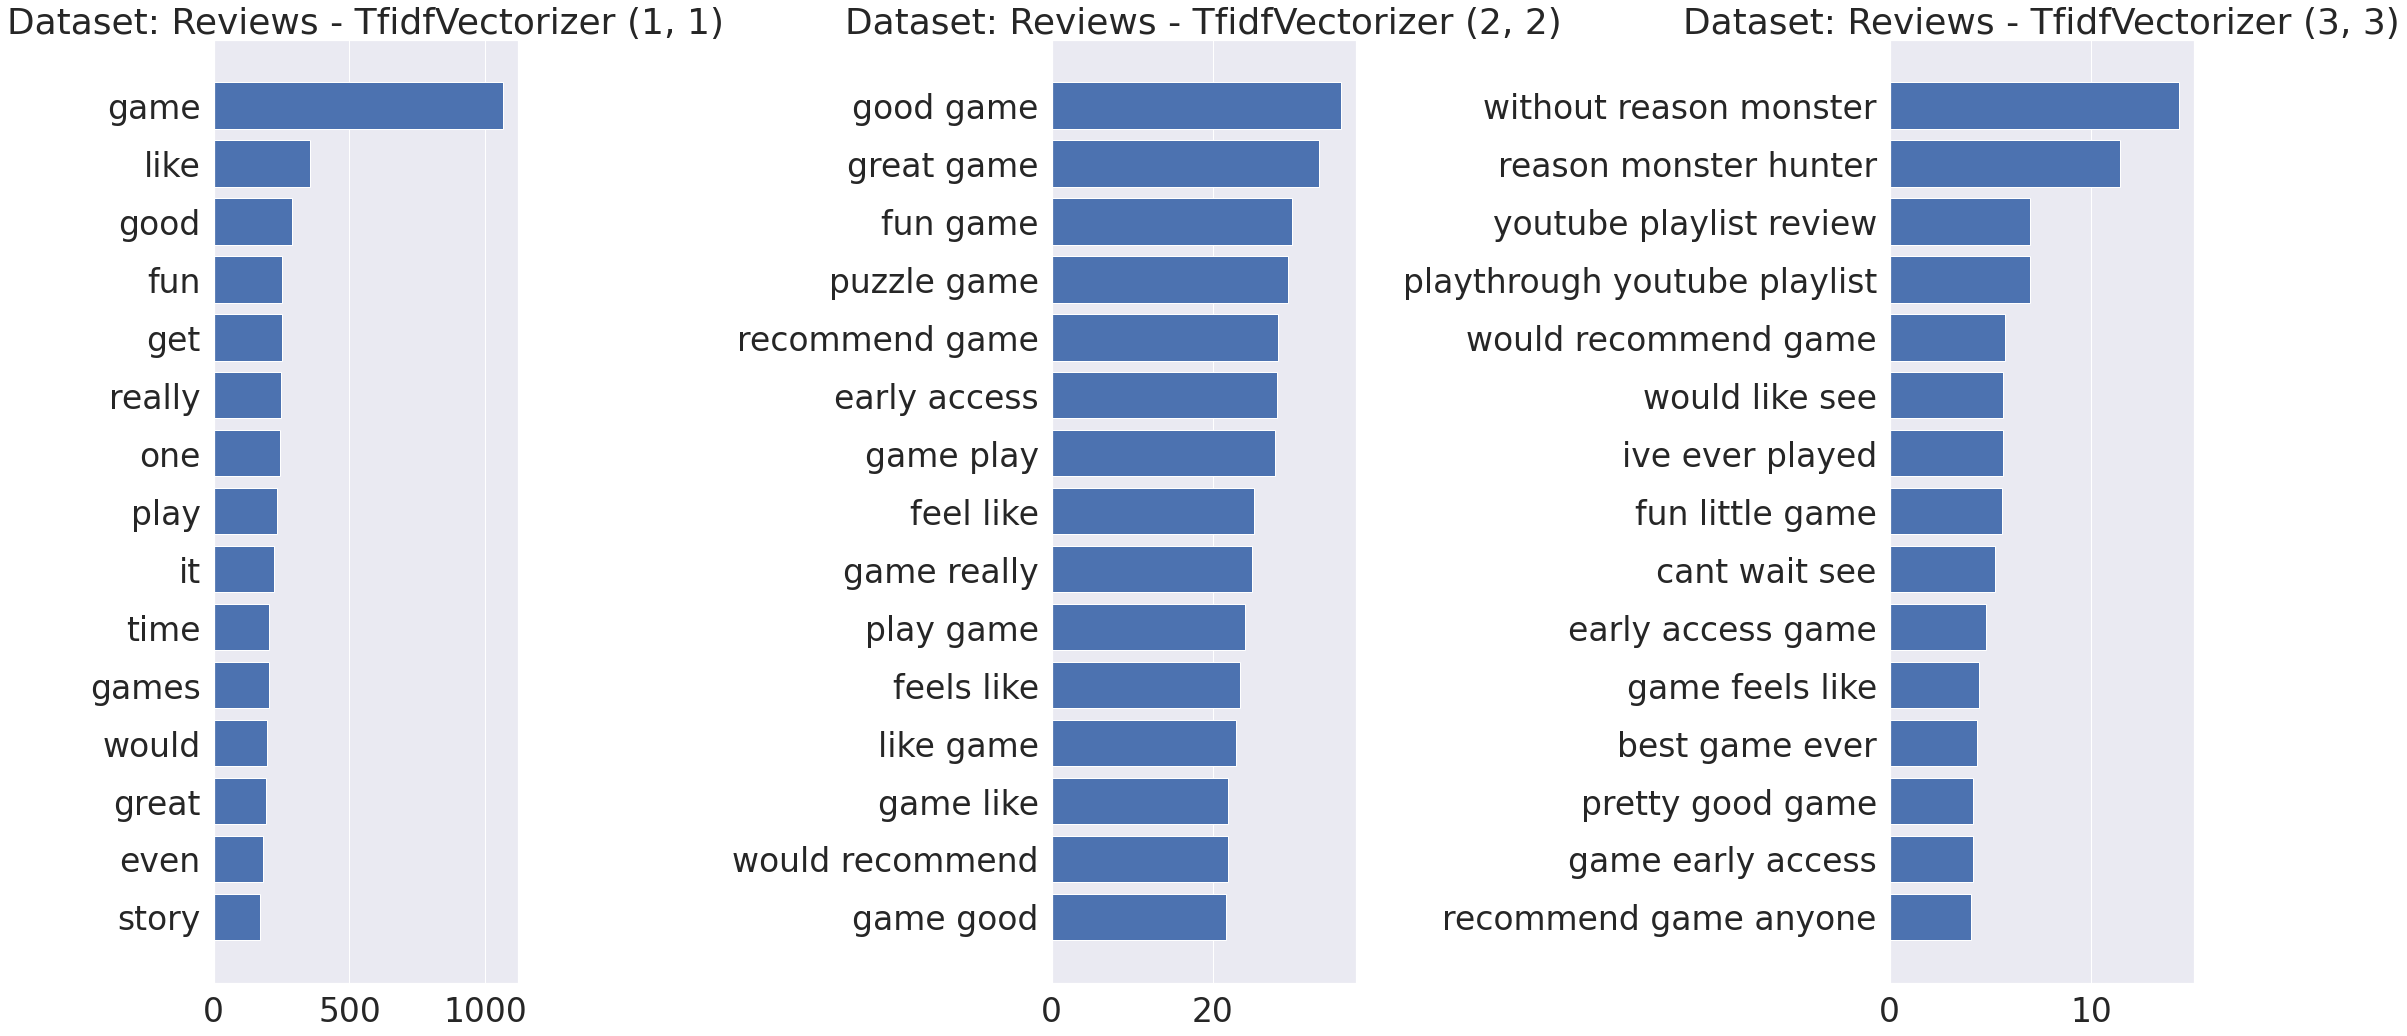

In [15]:
countplots(GameData[GameData["Top Reviews by Upvotes.1"].isnull() ==False]["Top Reviews by Upvotes.1"],"Reviews",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


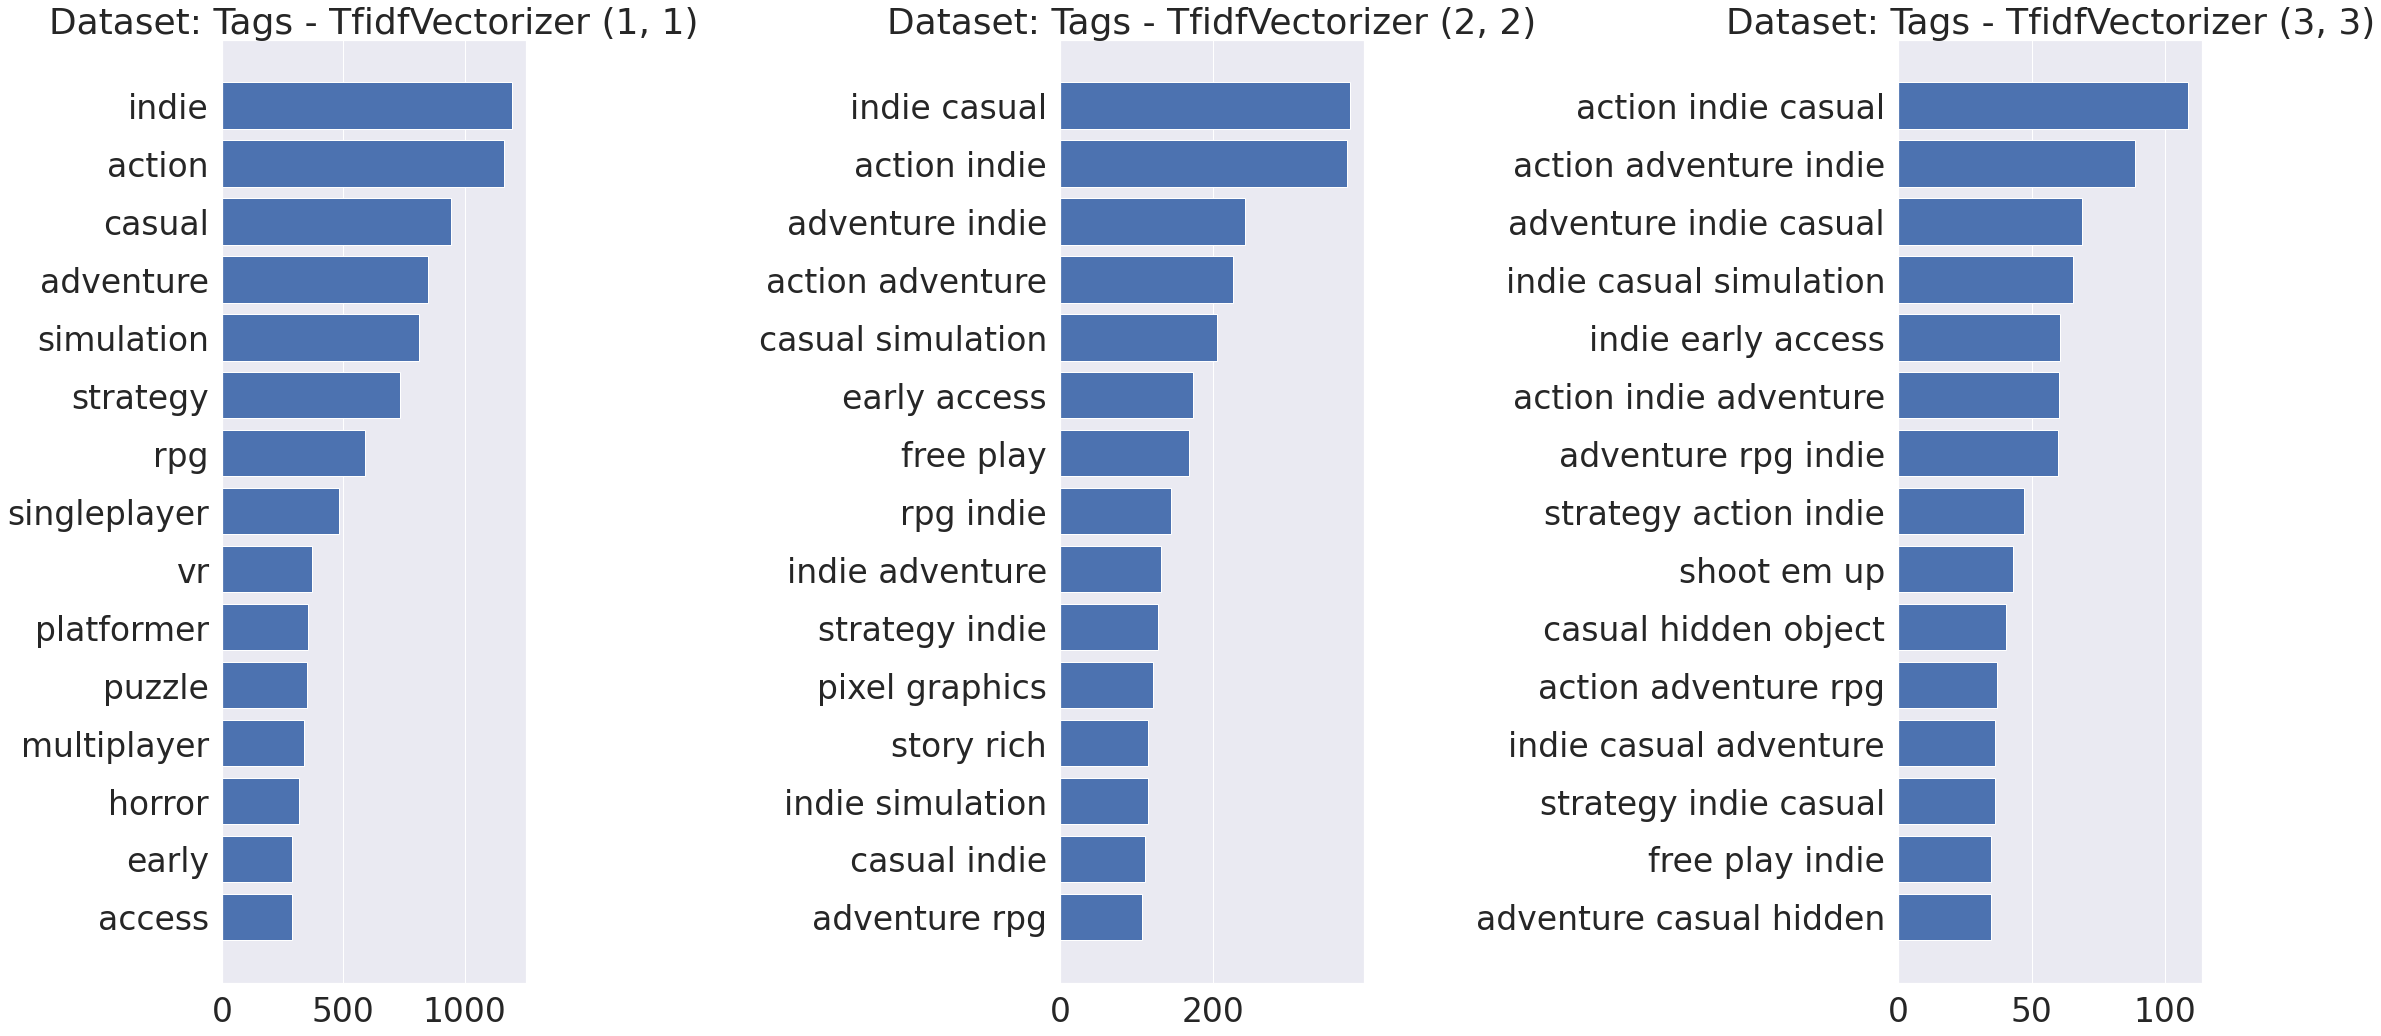

In [16]:
countplots(GameData[GameData["tags.1"].isnull() ==False]['tags.1'],"Tags",[TfidfVectorizer],cols=3)

## Gensim Keyword Extraction

In [17]:
# #Create function to get the top 10 gensim keywords for each column
# def getGensimKeywords(df, col, num_KW=10):
#     '''
#     Input: dataframe, target column, and number of keywords
#     Output, dataframe containing the keywords from that corpus of text
#     '''

#     # KeywordDict = {}
#     # for col in colList:
#     text = ''
#     for textstring in df[col]:
#         text = text + textstring
#     Keywords = keywords(text, words = num_KW, scores = True) #Returns list of keywords and their relevance scores
#         # KeywordDict.update({col:Keywords})
#     return pd.DataFrame(Keywords)

In [18]:
# Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]

# KeywordDict = {}
# for col in Columns:
#     Keywords = getGensimKeywords(GameData[GameData[col].isnull() ==False], col)
#     KeywordDict.update({col:Keywords})
#     print(Keywords)


## Spacy Keyword Extraction

In [24]:
# https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c

def getSpacyKeywords(df, colList, num_KW=10):
    '''
    Input: dataframe, target column, and number of keywords
    Output, dataframe containing the keywords from that corpus of text
    '''
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("textrank") #https://derwen.ai/docs/ptr/start/

    KeywordDict = {}
    for col in colList:
        text = ''
        for textstring in df[col]:
            if str(textstring)!='nan':
                text = text + str(textstring)
        nlp.max_length = 2000000
        doc = nlp(text[0:2000000])
        phrases = []
        for phrase in doc._.phrases:
            phrases.append((phrase.text, phrase.rank))
        Keywords = sorted(list(set(phrases))[0:num_KW],key=itemgetter(1), reverse = True)
        KeywordDict.update({col:Keywords})
        print(col, Keywords)
    print(KeywordDict)
    return pd.DataFrame(KeywordDict)

In [25]:
Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]
Keywords = getSpacyKeywords(GameData, Columns)

detailed_description.1 [('back roots hacker evolution games', 0.03008561115469065), ('extraction point extraction point', 0.016514925882673535), ('single choices', 0.01641352951127091), ('mechs buildings', 0.011966179382081806), ('2016 place area', 0.009767609613524738), ('fire flank manoeuvers', 0.009152132705450048), ('southern continent farien citystate union caldis', 0.00601629307275299), ('truly russian spirit atmosphere', 0.004990581850842891), ('overrun goblins skeletons', 0.00457024888512264), ('26x22', 0.0)]
Top Reviews by Upvotes.1 [('riduculous especially simple game', 0.05076083421342698), ('story way', 0.03765718059437312), ('looking cars customizationi', 0.02677896633391174), ('fought boss idea beat character', 0.026719085497228026), ('strongest part', 0.019934440332436857), ('continual support updates', 0.01493769273182516), ('boss', 0.013624207464643906), ('health power ups', 0.010814890718444704), ('id wasting guys', 0.009279623530330579), ('newly brainwashed deputy re

In [26]:
Keywords

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(back roots hacker evolution games, 0.03008561...","(riduculous especially simple game, 0.05076083...","(singleplayer action, 0.05901659235015084)"
1,"(extraction point extraction point, 0.01651492...","(story way, 0.03765718059437312)",(fastpaced puzzle platformer strategy adven...
2,"(single choices, 0.01641352951127091)","(looking cars customizationi, 0.02677896633391...",(indie puzzle visual novel cute strategy ...
3,"(mechs buildings, 0.011966179382081806)","(fought boss idea beat character, 0.0267190854...",(racing time attack indie simulation violen...
4,"(2016 place area, 0.009767609613524738)","(strongest part, 0.019934440332436857)",( minimalist survival horror dark action ca...
5,"(fire flank manoeuvers, 0.009152132705450048)","(continual support updates, 0.01493769273182516)","(shooter survival arcade, 0.024936980292004078)"
6,(southern continent farien citystate union cal...,"(boss, 0.013624207464643906)","( psychedelic colorful arcade, 0.01837183405..."
7,"(truly russian spirit atmosphere, 0.0049905818...","(health power ups, 0.010814890718444704)","( indie turnbased scifi, 0.01336228081001424)"
8,"(overrun goblins skeletons, 0.00457024888512264)","(id wasting guys, 0.009279623530330579)","( d arcade, 0.011101627431863756)"
9,"(26x22, 0.0)","(newly brainwashed deputy returning gun, 0.006...","(split, 0.007247324656801846)"


## Yake Keyword Extraction

In [27]:
# https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c

def getYakeKeywords(df, colList, num_KW=10, ngram = 3):
    '''
    Input: dataframe, target column, and number of keywords
    Output, dataframe containing the keywords from that corpus of text
    '''
    kw_extractor = yake.KeywordExtractor()
    language = "en"
    max_ngram_size = ngram
    deduplication_threshold = 0.9
    numOfKeywords = num_KW
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

    KeywordDict = {}
    for col in colList:
        text = ''
        for textstring in df[col]:
            if str(textstring)!='nan':
                text = text + str(textstring)
        Keywords = custom_kw_extractor.extract_keywords(text)
        KeywordDict.update({col:Keywords})
        print(col, Keywords)
    print(KeywordDict)
    return pd.DataFrame.from_dict(KeywordDict)


In [28]:
Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]
Keywords = getYakeKeywords(GameData, Columns)
Keywords

detailed_description.1 [('game game player', 1.447187033077952e-07), ('game', 8.631380045905295e-07), ('game player combats', 9.338090747886969e-07), ('game game', 1.3140490932528956e-06), ('puzzle adventure game', 1.3152156076349095e-06), ('game modes', 1.9498517479034874e-06), ('shooting game game', 2.1608650358843382e-06), ('game players', 2.220115120091246e-06), ('game play', 2.3772631863219112e-06), ('include map pack', 2.5885598021554455e-06)]
Top Reviews by Upvotes.1 [('game good game', 6.619019992835274e-08), ('game', 7.425624549507088e-08), ('game game', 7.830112807588496e-08), ('game play game', 9.762230750573915e-08), ('game fun game', 1.0297819438960037e-07), ('game game game', 1.425851826856405e-07), ('play game game', 1.496875381754667e-07), ('game great game', 1.6575382121694145e-07), ('fun game game', 1.6733956588310061e-07), ('game game play', 1.7271639020246153e-07)]
tags.1 [('action indie casual', 1.432448838286912e-08), ('action adventure indie', 1.7758314778857145e

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(game game player, 1.447187033077952e-07)","(game good game, 6.619019992835274e-08)","(action indie casual, 1.432448838286912e-08)"
1,"(game, 8.631380045905295e-07)","(game, 7.425624549507088e-08)","(action adventure indie, 1.7758314778857145e-08)"
2,"(game player combats, 9.338090747886969e-07)","(game game, 7.830112807588496e-08)","(action indie adventure, 2.6108250866929048e-08)"
3,"(game game, 1.3140490932528956e-06)","(game play game, 9.762230750573915e-08)","(adventure indie casual, 2.8519835183856032e-08)"
4,"(puzzle adventure game, 1.3152156076349095e-06)","(game fun game, 1.0297819438960037e-07)","(indie action adventure, 3.488801664518837e-08)"
5,"(game modes, 1.9498517479034874e-06)","(game game game, 1.425851826856405e-07)","(indie casual simulation, 3.831228370086682e-08)"
6,"(shooting game game, 2.1608650358843382e-06)","(play game game, 1.496875381754667e-07)","(indie casual adventure, 4.2651285049730645e-08)"
7,"(game players, 2.220115120091246e-06)","(game great game, 1.6575382121694145e-07)","(indie action indie, 4.4145710237887037e-08)"
8,"(game play, 2.3772631863219112e-06)","(fun game game, 1.6733956588310061e-07)","(indie casual action, 4.4764026196466e-08)"
9,"(include map pack, 2.5885598021554455e-06)","(game game play, 1.7271639020246153e-07)","(casual action indie, 4.4764026196466e-08)"


## Pre and During Covid Analyses

In [29]:
#Create Pre and During Covid data sets to use later:
preCOVID = GameData[GameData['Release Year'].isin([2018,2019])]
COVID = GameData[GameData['Release Year'].isin([2021,2022])]

In [ ]:
preCOVID.describe()

In [ ]:
COVID.describe()

In [ ]:
#Bar graph of Genre Frequencies

Genres = ['Action', 'Casual',
       'Indie', 'Simulation', 'Strategy', 'Early Access', 'Racing', 'RPG',
       'Adventure', 'Education', 'Game Development', 'Massively Multiplayer',
       'Design & Illustration', 'Web Publishing', 'Violent',
       'Gore', 'Sports', 'Animation & Modeling', 'Audio Production',
       'Software Training', 'Utilities', 'Video Production', 'Photo Editing',
       ]
sns.set(font_scale = 1)  
Freq = {}
for item in Genres:
    Freq.update({item:preCOVID[item].sum()})
    
Gen_Freq = pd.DataFrame.from_dict(Freq, orient = 'index').reset_index()
Gen_Freq = Gen_Freq.rename(columns = {'index': 'Genre', 0: 'Game Count'})
Gen_Freq = Gen_Freq.sort_values('Game Count')

fig = plt.figure(figsize = (20, 10))
Genre = Gen_Freq['Genre']
Counts = Gen_Freq['Game Count']
# creating the Horizontal bar plot

fig, ax = plt.subplots()
y_pos = np.arange(len(Genre))
 
hbars = ax.barh(y_pos, Counts/4190, align='center')
plt.yticks(y_pos, Genre)
plt.xlabel("Genre")
plt.ylabel("Number of Games")
plt.title("Percentage  Total Games by Genre, 2018-2019")
# Label with specially formatted floats
ax.bar_label(hbars)

plt.savefig("GamesbyGenre_preCOVID.png", bbox_inches="tight")

In [ ]:
Freq = {}
for item in Genres:
    Freq.update({item:COVID[item].sum()})
    
Gen_Freq = pd.DataFrame.from_dict(Freq, orient = 'index').reset_index()
Gen_Freq = Gen_Freq.rename(columns = {'index': 'Genre', 0: 'Game Count'})
Gen_Freq = Gen_Freq.sort_values('Game Count')

fig = plt.figure(figsize = (20, 10))
Genre = Gen_Freq['Genre']
Counts = Gen_Freq['Game Count']
# creating the Horizontal bar plot

fig, ax = plt.subplots()
y_pos = np.arange(len(Genre))
 
hbars = ax.barh(y_pos, Counts/3560, align='center')
plt.yticks(y_pos, Genre)
plt.xlabel("Genre")
plt.ylabel("Number of Games")
plt.title("Percentage  Total Games by Genre, 2021-2022")
# Label with specially formatted floats
ax.bar_label(hbars)

plt.savefig("GamesbyGenre_COVID.png", bbox_inches="tight")

In [ ]:
Categories = ['Single-player', 'Steam Achievements', 'Steam Workshop',
       'Steam Cloud', 'Includes level editor', 'Downloadable Content',
       'Multi-player', 'Shared/Split Screen', 'Full controller support',
       'Steam Trading Cards', 'Remote Play Together',
       'Partial Controller Support', 'Steam Leaderboards',
       'Captions available', 'Stats', 'PvP', 'Online PvP', 'Co-op',
       'Online Co-op', 'MMO', 'In-App Purchases', 'Shared/Split Screen PvP',
       'Shared/Split Screen Co-op', 'Cross-Platform Multiplayer', 'LAN PvP',
       'LAN Co-op', 'Valve Anti-Cheat enabled', 'Remote Play on TV',
       'VR Support', 'Remote Play on Phone', 'Remote Play on Tablet']

Freq = {}
for cat in Categories:
    Freq.update({cat:preCOVID[cat].sum()})
    
Cat_Freq = pd.DataFrame.from_dict(Freq, orient = 'index').reset_index()
Cat_Freq = Cat_Freq.rename(columns = {'index': 'Category', 0: 'Game Count'})
Cat_Freq = Cat_Freq.sort_values('Game Count')

fig = plt.figure(figsize = (20, 10))
Category = Cat_Freq['Category']
Counts = Cat_Freq['Game Count']
# creating the Horizontal bar plot

fig, ax = plt.subplots()
y_pos = np.arange(len(Category))
 
hbars = ax.barh(y_pos, Counts/4190, align='center')
plt.yticks(y_pos, Category)
plt.xlabel("Category")
plt.ylabel("Number of Games")
plt.title("Number of Games by Category, 2018-2019")
# Label with specially formatted floats
ax.bar_label(hbars)

plt.savefig("GamesbyCategory_preCOVID.png", bbox_inches="tight")

In [ ]:
Freq = {}
for cat in Categories:
    Freq.update({cat:COVID[cat].sum()})
    
Cat_Freq = pd.DataFrame.from_dict(Freq, orient = 'index').reset_index()
Cat_Freq = Cat_Freq.rename(columns = {'index': 'Category', 0: 'Game Count'})
Cat_Freq = Cat_Freq.sort_values('Game Count')

fig = plt.figure(figsize = (20, 10))
Category = Cat_Freq['Category']
Counts = Cat_Freq['Game Count']
# creating the Horizontal bar plot

fig, ax = plt.subplots()
y_pos = np.arange(len(Category))
 
hbars = ax.barh(y_pos, Counts/3560, align='center')
plt.yticks(y_pos, Category)
plt.xlabel("Category")
plt.ylabel("Number of Games")
plt.title("Number of Games by Category, 2021-2022")
# Label with specially formatted floats
ax.bar_label(hbars)

plt.savefig("GamesbyCategory_COVID.png", bbox_inches="tight")

In [ ]:
countplots(preCOVID[preCOVID["detailed_description.1"].isnull() ==False]["detailed_description.1"],"PreCOVID Desc",[TfidfVectorizer],cols=3)

In [ ]:
countplots(COVID[COVID["detailed_description.1"].isnull() ==False]["detailed_description.1"],"COVID Desc",[TfidfVectorizer],cols=3)

In [ ]:
countplots(preCOVID[preCOVID["Top Reviews by Upvotes.1"].isnull() ==False]["Top Reviews by Upvotes.1"],"PreCOVID Reviews",[TfidfVectorizer],cols=3)

In [ ]:
countplots(COVID[COVID["Top Reviews by Upvotes.1"].isnull() ==False]["Top Reviews by Upvotes.1"],"COVID Reviews",[TfidfVectorizer],cols=3)

In [ ]:
countplots(preCOVID[preCOVID["tags.1"].isnull() ==False]['tags.1'],"Tags, preCOVID",[TfidfVectorizer],cols=3)

In [ ]:
countplots(COVID[COVID["tags.1"].isnull() ==False]['tags.1'],"Tags, COVID",[TfidfVectorizer],cols=3)

In [30]:
Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]
Keywords = getSpacyKeywords(preCOVID, Columns)
Keywords

detailed_description.1 [('past24 levels', 0.027284430145942576), ('summon favourite characters', 0.02508988052578466), ('several missions', 0.017007723443376616), ('30 levels increasing difficulty', 0.016997038805365926), ('explore fightin', 0.013914416084655979), ('stab back itdevelopment historyclick zoomfeaturesonline coop campaign  entire campaign online friends', 0.011094741558419541), ('regular population', 0.007645052064366886), ('bögenhafennew cosmetics', 0.0031582921669026038), ('francis marion', 0.0020883163455284173), ('26x22', 0.0)]
Top Reviews by Upvotes.1 [('overall dtgs best dlc', 0.03896471074111614), ('boil thing', 0.02642990434167824), ('nice touch bit bombastic top', 0.02555631918805661), ('sense problem', 0.018084078445768318), ('combat jank shit', 0.014321005717541212), ('round start scenarioservice hope', 0.014307758753117154), ('left mouse button', 0.013826801527338683), ('12 years age', 0.00852190324657322), ('winnernot good', 0.008012449579512677), ('excellent 

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(past24 levels, 0.027284430145942576)","(overall dtgs best dlc, 0.03896471074111614)","( local coop free play, 0.042317934960542654)"
1,"(summon favourite characters, 0.02508988052578...","(boil thing, 0.02642990434167824)",( local multiplayer coop campaign story rich...
2,"(several missions, 0.017007723443376616)","(nice touch bit bombastic top, 0.0255563191880...",(indie casual anime drama story rich rpg ...
3,"(30 levels increasing difficulty, 0.0169970388...","(sense problem, 0.018084078445768318)",( turnbased strategy d story rich turnbased...
4,"(explore fightin, 0.013914416084655979)","(combat jank shit, 0.014321005717541212)","( puzzle singleplayer, 0.029451409021820002)"
5,(stab back itdevelopment historyclick zoomfeat...,"(round start scenarioservice hope, 0.014307758...","( simulation, 0.025263712704493416)"
6,"(regular population, 0.007645052064366886)","(left mouse button, 0.013826801527338683)","( dark humor action survival, 0.025165425722..."
7,"(bögenhafennew cosmetics, 0.0031582921669026038)","(12 years age, 0.00852190324657322)",( action bullet hell difficult indie level...
8,"(francis marion, 0.0020883163455284173)","(winnernot good, 0.008012449579512677)","( procedural generation, 0.018383851464942556)"
9,"(26x22, 0.0)",(excellent 1010 ultimate spookinessdicey dunge...,(survival fps immersive sim d colorful fi...


In [31]:
Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]
Keywords = getSpacyKeywords(COVID, Columns)
Keywords

detailed_description.1 [('first simple kill game', 0.051442225620804194), ('ability option', 0.020783961482743613), ('exotic skins bundlexenia’s ark  4x strategy game', 0.020646881907746474), ('intangible ability', 0.016862919958021874), ('right dpad right ui discard special right item', 0.01603945070457273), ('extra special route huge thanks generous kickstarter backer', 0.01501022347598461), ('videos lookup tables', 0.011960672431110056), ('favourite background', 0.01062273330618909), ('much least complicate passage help robot', 0.00975454282227896), ('dxhttpsstoresteampoweredcomapp1502970atelier lydie', 0.002388835837376529)]
Top Reviews by Upvotes.1 [('ugly best part', 0.03997156501750504), ('long enough build rocket ship interesting spin tetris casual play', 0.023071540905557953), ('8 hours day shopping', 0.01619314767242307), ('either puzzles', 0.011341547482981058), ('simply close support tickets', 0.007710387249679681), ('a key fast swap', 0.006806289690391782), ('prep launches

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(first simple kill game, 0.051442225620804194)","(ugly best part, 0.03997156501750504)","( indie action early access, 0.03889503304776..."
1,"(ability option, 0.020783961482743613)",(long enough build rocket ship interesting spi...,"( automobile sim strategy rpg, 0.035488341093..."
2,(exotic skins bundlexenia’s ark 4x strategy g...,"(8 hours day shopping, 0.01619314767242307)","(stylized action arcade, 0.03365090224376734)"
3,"(intangible ability, 0.016862919958021874)","(either puzzles, 0.011341547482981058)","( survival horror, 0.030950635829544826)"
4,(right dpad right ui discard special right ite...,"(simply close support tickets, 0.0077103872496...",( puzzle city builder action arcade side sc...
5,(extra special route huge thanks generous kick...,"(a key fast swap, 0.006806289690391782)","(puzzleplatformer, 0.028254349215002163)"
6,"(videos lookup tables, 0.011960672431110056)","(prep launches, 0.006582681049843422)",( atmospheric family friendly fantasy manag...
7,"(favourite background, 0.01062273330618909)","(folks, 0.004745708325303372)",( colorful pixel graphics stylized old scho...
8,"(much least complicate passage help robot, 0.0...","(f u face, 0.004253489272162016)",( vr asymmetric vr puzzle atmospheric first...
9,(dxhttpsstoresteampoweredcomapp1502970atelier ...,"(one fish, 0.002048568888214384)","( rts, 0.007912642727947164)"


In [32]:
Keywords = getYakeKeywords(preCOVID, Columns)
Keywords

detailed_description.1 [('game', 5.699341869363522e-06), ('puzzle adventure game', 1.4111894031884502e-05), ('time purchase fantasy', 1.6162911601854352e-05), ('game modes', 2.4379668863746732e-05), ('puzzle game', 2.5985776065075734e-05), ('game play', 2.734263680117904e-05), ('adventure game', 2.7757277777895838e-05), ('game game', 2.9225926534143793e-05), ('game point character', 3.2373882661568154e-05), ('fantasy grounds full', 3.287954207032703e-05)]
Top Reviews by Upvotes.1 [('game', 5.265078255035147e-07), ('game good game', 8.699218530861034e-07), ('game game', 8.856097205033911e-07), ('game fun game', 1.0719056487747806e-06), ('game play game', 1.312197950394716e-06), ('play game game', 1.5308976087938353e-06), ('game play', 1.8381702896137763e-06), ('game story game', 1.8827077204794709e-06), ('good game', 1.9354897003436813e-06), ('game played game', 2.018777031350949e-06)]
tags.1 [('action indie casual', 3.551735436559843e-08), ('action indie adventure', 5.768518555480344e-

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(game, 5.699341869363522e-06)","(game, 5.265078255035147e-07)","(action indie casual, 3.551735436559843e-08)"
1,"(puzzle adventure game, 1.4111894031884502e-05)","(game good game, 8.699218530861034e-07)","(action indie adventure, 5.768518555480344e-08)"
2,"(time purchase fantasy, 1.6162911601854352e-05)","(game game, 8.856097205033911e-07)","(action adventure indie, 6.076172878439296e-08)"
3,"(game modes, 2.4379668863746732e-05)","(game fun game, 1.0719056487747806e-06)","(adventure indie casual, 6.287726345228647e-08)"
4,"(puzzle game, 2.5985776065075734e-05)","(game play game, 1.312197950394716e-06)","(indie action indie, 6.610766815557578e-08)"
5,"(game play, 2.734263680117904e-05)","(play game game, 1.5308976087938353e-06)","(indie casual simulation, 7.795678694250401e-08)"
6,"(adventure game, 2.7757277777895838e-05)","(game play, 1.8381702896137763e-06)","(indie casual adventure, 8.206015738688232e-08)"
7,"(game game, 2.9225926534143793e-05)","(game story game, 1.8827077204794709e-06)","(indie casual action, 9.44438741085231e-08)"
8,"(game point character, 3.2373882661568154e-05)","(good game, 1.9354897003436813e-06)","(indie casual indie, 9.515435158605841e-08)"
9,"(fantasy grounds full, 3.287954207032703e-05)","(game played game, 2.018777031350949e-06)","(adventure rpg indie, 1.0855360662040683e-07)"


In [33]:
Keywords = getYakeKeywords(COVID, Columns)
Keywords

detailed_description.1 [('game game player', 9.353267251878826e-07), ('game player combats', 4.381149215001486e-06), ('shooting game game', 5.9842745577572826e-06), ('include map pack', 6.057901780808838e-06), ('dlc include map', 6.757356229635727e-06), ('game', 6.814946943629383e-06), ('gamein game players', 7.453923596191934e-06), ('game game', 8.093067276671183e-06), ('game feature dlc', 1.0586888149997543e-05), ('game players', 1.1402042295257617e-05)]
Top Reviews by Upvotes.1 [('game', 1.7029295270967624e-06), ('monika monika monika', 2.744135429833959e-06), ('real isnt real', 3.4428682288624685e-06), ('game game play', 3.689703299538649e-06), ('game game', 3.898953953091874e-06), ('isnt real isnt', 4.778934015369239e-06), ('game fun game', 5.760081903369954e-06), ('game game game', 5.824319039311906e-06), ('game play', 6.434440437181686e-06), ('game good game', 6.657847362282727e-06)]
tags.1 [('singleplayer early access', 7.569528534218686e-07), ('story rich singleplayer', 8.4300

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(game game player, 9.353267251878826e-07)","(game, 1.7029295270967624e-06)","(singleplayer early access, 7.569528534218686e..."
1,"(game player combats, 4.381149215001486e-06)","(monika monika monika, 2.744135429833959e-06)","(story rich singleplayer, 8.430011030354791e-07)"
2,"(shooting game game, 5.9842745577572826e-06)","(real isnt real, 3.4428682288624685e-06)","(singleplayer indie action, 8.450385822096719e..."
3,"(include map pack, 6.057901780808838e-06)","(game game play, 3.689703299538649e-06)","(singleplayer action adventure, 9.801954971711..."
4,"(dlc include map, 6.757356229635727e-06)","(game game, 3.898953953091874e-06)","(singleplayer indie casual, 1.1324850896853337..."
5,"(game, 6.814946943629383e-06)","(isnt real isnt, 4.778934015369239e-06)","(indie early access, 1.1887955286371653e-06)"
6,"(gamein game players, 7.453923596191934e-06)","(game fun game, 5.760081903369954e-06)","(rpg action rpg, 1.20966528924402e-06)"
7,"(game game, 8.093067276671183e-06)","(game game game, 5.824319039311906e-06)","(singleplayer casual adventure, 1.328223062006..."
8,"(game feature dlc, 1.0586888149997543e-05)","(game play, 6.434440437181686e-06)","(singleplayer adventure casual, 1.448970613097..."
9,"(game players, 1.1402042295257617e-05)","(game good game, 6.657847362282727e-06)","(indie action adventure, 1.458973943736506e-06)"
